# Predicting the Winners of the 2024 Champions League Football Tournament with Machine Learning Models

The UEFA Champions League is one of the most prestigious and widely followed football tournaments in the world, where Europe's elite clubs compete for the coveted trophy. With the 2024 edition on the horizon, football enthusiasts and data analysts like ourselves are turning to machine learning to gain insights and make predictions about the potential winners. By leveraging historical data, team statistics, player performance metrics, and advanced algorithms, these models aim to unravel the intricate patterns and dynamics that influence the outcomes of matches, and ultimately answer the question: **which football team will win the 2024 Champions League?** While the odds are certainly in favor of the stronger teams like Manchester City, Real Madrid, Bayern Munich, and Paris Saint-Germain, this project aims to narrow down our ultimate champion. We thought it would be quite interesting to apply class knowledge to an area we are very passionate about.

# Data Collection

The first step to this exploration and analysis would be gathering relevant data. To build good models, we need the data from the football teams. We need a dataset that explicitly outlines the performance of the different teams, which can be extracted from previous Champions League games from over the years. We settled on this [UEFA Champion league statistics (1993-2020)](https://www.kaggle.com/datasets/bakar31/ucl-statistics/data) Kaggle dataset, named `ucl_stats.csv` in our project directory. This source can be vewed as trustworthy as it was originally sourced from the official UEFA records, the international body in charge or organizing the tournament. For making our predictions after model training, we needed the cummulative/aggregated performance results of the current teams in the chamionship. We used another Kaggle dataset which can be found [here](https://www.kaggle.com/datasets/basharalkuwaiti/champions-league-era-stats?select=AllTimeRankingByClub.csv) to isolate the teams we needed.

We store our training dataset in the same folder as our current notebook and import it using panda's `read_csv()` method.

In [1]:
import pandas as pd
data = pd.read_csv("ucl_stats.csv")
data

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...,...
709,2020,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,2020,Valencia,8,3,2,3,13,15,-2,11,0
711,2020,Chelsea,8,3,2,3,12,16,-4,11,0
712,2020,Ajax,6,3,1,2,12,6,6,10,0


To get a general overview of the dataset, features it contains and descriptive numerical statistics, we apply the `info()` and `describe()` methods on our read dataset.

In [2]:
# View available columns and related info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            714 non-null    int64 
 1   team            714 non-null    object
 2   match_played    714 non-null    int64 
 3   wins            714 non-null    int64 
 4   draws           714 non-null    int64 
 5   losts           714 non-null    int64 
 6   goals_scored    714 non-null    int64 
 7   goals_conceded  714 non-null    int64 
 8   gd              714 non-null    int64 
 9   group_point     714 non-null    int64 
 10  champions       714 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 61.5+ KB


In [3]:
# Quick view of descriptive statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,714.0,2008.711485,7.340121,1993.0,2004.0,2009.0,2015.0,2020.0
match_played,714.0,7.673669,2.100880,6.0,6.0,6.0,8.0,13.0
wins,714.0,2.939776,2.316600,0.0,1.0,2.0,4.0,11.0
draws,714.0,1.844538,1.273169,0.0,1.0,2.0,3.0,7.0
losts,714.0,2.892157,1.234552,0.0,2.0,3.0,4.0,6.0
goals_scored,714.0,10.582633,6.979194,0.0,5.0,9.0,14.0,43.0
goals_conceded,714.0,10.443978,3.634080,2.0,8.0,10.0,13.0,24.0
gd,714.0,0.198880,7.573646,-22.0,-5.0,0.0,5.0,35.0
group_point,714.0,8.183473,4.192922,-8.0,5.0,8.0,11.0,18.0
champions,714.0,0.039216,0.194244,0.0,0.0,0.0,0.0,1.0


In the dataframes above, we can see all the features currentlly in our dataset. This information is certainly crucial and sems to contain all the information we need to explore our problem statement, albeit with some minor upgrades and/or updates.

## Data Cleaning

Now that we have our dataset stored in the `data` variable and ready to go, the next logical step for data analysis is to clean the data. This step scans the data set and ensures there are no missing values or inconsistent values in our dataset.

In [4]:
# Check for missing values
data.isna().sum()  

year              0
team              0
match_played      0
wins              0
draws             0
losts             0
goals_scored      0
goals_conceded    0
gd                0
group_point       0
champions         0
dtype: int64

In [5]:
# Check for duplicates
duplicates = data[data.duplicated()]
print("Number of duplicates: ", len(duplicates))

Number of duplicates:  0


Our dataset doesn't seem to contain any duplicate records. Next we scan our dataset to drop records that contain any logical incosistencies. This is done to ensure the legitimacy of our results. We need to confirm that the wins, losses, and draws sum up to the total number of games played, and that the goal differences are actually consistent with the differences between the goals scored and goals conceded. We write a function to do these checks and call that function.

In [6]:
# Function to handle any possible inconsistencies in our dataset
def fix_inconsistencies(data):
    # Ensure that matches played = wins + draws + losses
    data = data[data['wins'] + data['draws'] + data['losts'] == data['match_played']]
    
    # Check that Goal Diff = Goals For - Goals Against
    data = data[data['goals_scored'] - data['goals_conceded'] == data['gd']]
    
    return data

cleaned_df = fix_inconsistencies(data.copy()) # Using a copy of the original data set
cleaned_df

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...,...
709,2020,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,2020,Valencia,8,3,2,3,13,15,-2,11,0
711,2020,Chelsea,8,3,2,3,12,16,-4,11,0
712,2020,Ajax,6,3,1,2,12,6,6,10,0


It seems a few inconsistencies were discovered and subsequently dropped from our dataset. How do we know? Take a look at the total number of rows in our original dataset and compare them with the total number of rows in the current dataset after running our cleanup function. The total number of rows drops from `714` to `685`. This means that `29` records with incosistent data were dropped from our dataset. 

# Feature Selection/Engineering

At this stage, we need to update/upgrade our features to get them ready to go for modelling. This is where we must ensure we have the right features we need to make accurate predictions. First, we rename some features to further clarify what they represent. Unneccessary features are dropped from the dataset here as well, in addition to encoding categorical variables. From the existing attributes, we also need to build new features in order to provide important metrics that might serve to improve our model's prerformance.

In [7]:
# Rename features
df = cleaned_df # Renamed for easier typing and more cleaner code
df = df.rename(columns={'match_played': 'matches_played', 'losts': 'losses', 'gd': 'goal_diff'})
df.head()

,year,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0


From the printed dataset, we can see that we now have more gramatically correct feature names, all written in full and multple words separated with underscores to provide clear insights into their meanings while still conforming with Python syntax rules.

Next, we drop the `year` feature as we deem it unimportant for the training and testing of our models. It adds very little to no value to the problem we are trying to tackle and the way we have chosen to tackle it.

In [8]:
# Drop unnecessary features
df.drop(['year'], axis = 1, inplace = True)
df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions
0,Marseille,6,3,3,0,14,4,10,9,1
1,Milan,7,6,0,1,11,2,9,12,0
2,Rangers,6,2,4,0,7,5,2,8,0
3,Club Brugge,6,2,1,3,5,8,-3,5,0
4,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...
709,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,Valencia,8,3,2,3,13,15,-2,11,0
711,Chelsea,8,3,2,3,12,16,-4,11,0
712,Ajax,6,3,1,2,12,6,6,10,0


We need to encode the categorical features that still exist in our dataset. This is a very important step as the inbuilt `scikit-learn` model builders/classifiers do not work too well with categorical data. This step is essential to prevent any related errors from arising during the training of our models. The only categorical data we have in our dataset now is the `team` feature. Hence, we go ahead and encode it using `pandas` built-in methods.

In [9]:
# Encode team column
df['team'] = df['team'].astype('category').cat.codes

### Building new features

While the features we currently have provide meaningful insights into each team's performance, it might be beneficial to build more numerical feautures from these existing features. A few inherent relationships might exist between these present features that provide stronger insights to perfromance. Ratios and differences are often good ways of analyzing relationships between features, so we go ahead to construct a few ratios and differences from our current variables and add them to our dataset.

**Note:** Whenever you create ratios or quotients, it is always necessary to put checks in place against division by zero. This will prevent any errors that may arise from attempts to perform these divisions.  We went about this by adding `1` to the denominators where a zero may occur. In our case, they are the `losses` and `goals_scored` features. It is necessary we add `1` only to the denominator so that divisions by zero are considered zeros and alllowed divisions still have consistent changes across these features.

In [10]:
# Build new Ratio features
df['Win_Ratio'] = (df['wins']) / df['matches_played']
df['Loss_Ratio'] = (df['losses']) / df['matches_played']
df['GoalsScored_to_Matches'] = (df['goals_scored']) / df['matches_played']
df['GoalsConceeded_to_Matches'] = (df['goals_conceded']) / df['matches_played']
df['Win_to_Loss'] = (df['wins']) / (df['losses'] + 1)
df['Wins_to_GoalsScored'] = (df['wins']) / (df['goals_scored'] + 1) 
df['GoalsScored_GoalsConceded'] = (df['goals_scored'] - df['goals_conceded'])

df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions,Win_Ratio,Loss_Ratio,GoalsScored_to_Matches,GoalsConceeded_to_Matches,Win_to_Loss,Wins_to_GoalsScored,GoalsScored_GoalsConceded
0,87,6,3,3,0,14,4,10,9,1,0.500000,0.000000,2.333333,0.666667,3.00,0.200000,10
1,88,7,6,0,1,11,2,9,12,0,0.857143,0.142857,1.571429,0.285714,3.00,0.500000,9
2,106,6,2,4,0,7,5,2,8,0,0.333333,0.000000,1.166667,0.833333,2.00,0.250000,2
3,43,6,2,1,3,5,8,-3,5,0,0.333333,0.500000,0.833333,1.333333,0.50,0.333333,-3
4,38,6,0,2,4,2,11,-9,2,0,0.000000,0.666667,0.333333,1.833333,0.00,0.000000,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,140,6,2,1,3,7,9,-2,7,0,0.333333,0.500000,1.166667,1.500000,0.50,0.250000,-2
710,134,8,3,2,3,13,15,-2,11,0,0.375000,0.375000,1.625000,1.875000,0.75,0.214286,-2
711,42,8,3,2,3,12,16,-4,11,0,0.375000,0.375000,1.500000,2.000000,0.75,0.230769,-4
712,10,6,3,1,2,12,6,6,10,0,0.500000,0.333333,2.000000,1.000000,1.00,0.230769,6


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685 entries, 0 to 713
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team                       685 non-null    int16  
 1   matches_played             685 non-null    int64  
 2   wins                       685 non-null    int64  
 3   draws                      685 non-null    int64  
 4   losses                     685 non-null    int64  
 5   goals_scored               685 non-null    int64  
 6   goals_conceded             685 non-null    int64  
 7   goal_diff                  685 non-null    int64  
 8   group_point                685 non-null    int64  
 9   champions                  685 non-null    int64  
 10  Win_Ratio                  685 non-null    float64
 11  Loss_Ratio                 685 non-null    float64
 12  GoalsScored_to_Matches     685 non-null    float64
 13  GoalsConceeded_to_Matches  685 non-null    float64
 14 

Above we can see a more detailed view of all the features we now have in our dataset, consisting of both the original features and newly engineered features.

### Feature Correlation

Now that we have all our intended features ready to go, we can analyze the correlations that exist among these features as well the the relationships between the individual features and the target variable. One great way to do this is using a correlation matrix. This provides a neat visual to explore these existing relationships. To use this, we make use of the Seaborn package's `heatmap` function. 

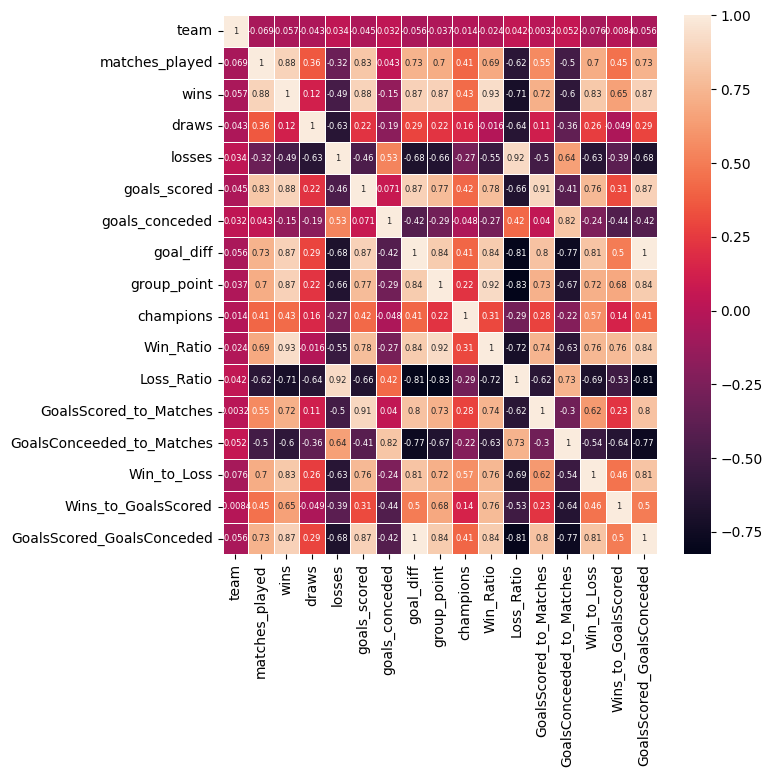

In [12]:
features = df.columns.tolist()
correlation = df[features].corr()

# Print the correlation matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(correlation, annot=True, annot_kws={"size": 6}, linewidths=0.5)
plt.show()

We can interpret the plot using the scale to the right. Here we see that lighter colors indicate a higher positive correlation where darker hues represent higher negative correlations. A red-purple color indicates little to no correlation.

### Preventing Overfitting - Cross Validation: Train/Test Split

We decided to use the Test set cross validation method for training our model. This is  This involves splitting our dataset into training and testing sets, training the model on the training setand evaluating its performance on the test set. We want to give the model as much data as possible to train with. However, we also want to make sure that we have enough data for the model to test itself on.

We split our data using the scikit-learn `train_test_split` function. In our case, since our dataset, we  is not very large, we chose 70% of the overall dataset for our training data and 30% for the test set to be somewhat fair to both training and testing. We set `stratify=y` to ensure that both the train and test sets have the same proportion of of the 0s and 1s in the target variable, `champions` as the original dataset.

In [13]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 2024
X = df.drop("champions", axis=1)
y = df['champions'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = RANDOM_SEED, stratify=y)

### Scaling/Standardizing Features

Before modeling, we need to standardie our data by scaling. We scale to control for the fact that different variables are measured on different scales. This is especially important to do before performing Principal Component Analyses (PCA). We scale so that each feature/predictor can have a fair chances against each other in deciding importance. We also convert `y_train` from a pandas series object into a numpy array for the model to accept the target training data later on.

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train)

## Explainability Analysis

### Principal Component Analysis (PCA)

Using Principal Component Analysis, we can explore the benefits of dimension reduction for our features or dataset. Dimension reduction simply means the ability to now approximate the original dataset with fewer variables/features, while reducing computational power to run our model. Using a PCA, we can study the cumulative explained variance ratio of these features to understand which features explain the most variance in the data.

For this, we will use the scikit-learn `PCA` function. We instantiate this function and set the number of components (features) that we want to consider. We’ll originally set it to `16` which includes all the independent features to see the explained variance of all the generated components, before deciding where to make the cut. Then we fit our scaled training data, `X_train data` to the PCA function.

In [15]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=16)
pca_test.fit(X_train_scaled)

PCA(n_components=16)

After performing the PCA, we plot the the graph of the cumulative explained variance in relation to the number of components we have. The x-value of this graph at the sharp curving point of our variance plot is usually a good indicator of the number of components that are responsible for most of the variance in our dataset. Consequently, this means that our model only needs this number of components to make its predictions.

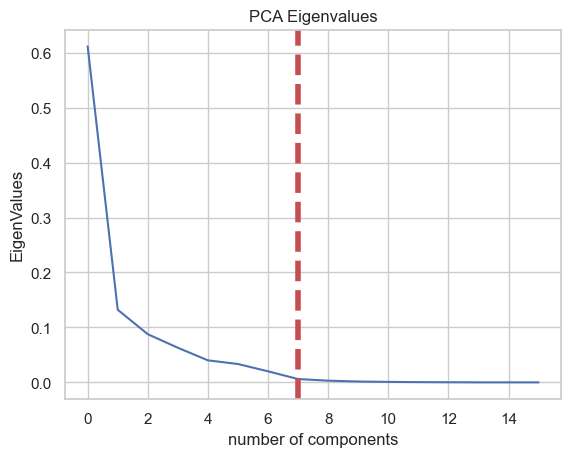

None

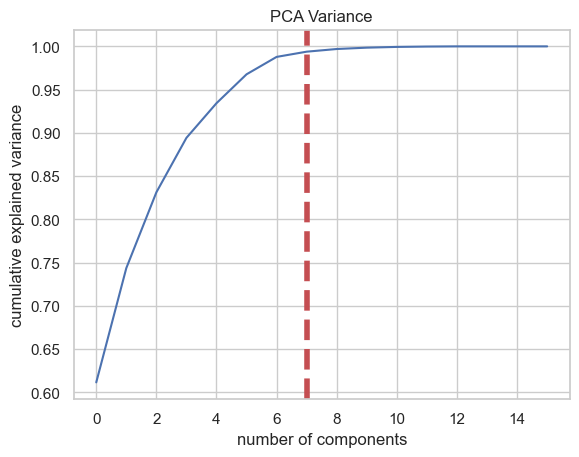

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.611462,0.611462
1,0.743590,0.132128
2,0.831226,0.087636
3,0.894227,0.063001
4,0.934296,0.040069
5,0.967703,0.033408
6,0.987828,0.020124


In [16]:
# Eigenvalues Plot (Elbow graph)
sns.set(style='whitegrid')
plt.plot(pca_test.explained_variance_ratio_)
plt.title("PCA Eigenvalues")
plt.xlabel('number of components')
plt.ylabel('EigenValues')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=7, ymin=0, ymax=1)
display(plt.show()) 

# Variance Plot
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.title("PCA Variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=7, ymin=0, ymax=1)
display(plt.show())


# Make table for the graph
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(7))

Looking at the graph above, we see that our variance curve makes a sharp turn at about 7 components. This is a good indicator that we might only need 7 components for our model.

Shifting focus to the dataframe just below the graph, we can observe that when we use PCA to reduce our 16 predicting variables down to 7 components, we can still explain over 98% of the variance. The other 9 components explain less than 2% of the variance, so we can cut them. Using this logic, we will use PCA to reduce the number of components from 16 to 7 for `X_train` and `X_test`. We will assign these recreated, reduced dimension datasets to `X_train_scaled_pca` and `X_test_scaled_pca`. This is done below.

In [17]:
pca = PCA(n_components=7)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

Each component is a combination of the original features with corresponding “weights”. These weights indicate the importance or influence of each original feature in determining the principal component. We tend to ntice both positive and negative values for these wights in our dataframe. How do these differ? Well, positive weights indicate that an increase in the feature caused an increase in the principal component score, whereas negative weights indicate that an increase in the original feature corresponded to a decrease in the principal component score. We can see these weigths for each PCA component by creating a dataframe below.

In [18]:
pca_dims = []
columns = ['team', 'matches_played', 'wins', 'draws', 'losses', 'goals_scored', 'goals_conceded', 'goal_diff', 'group_point', 'Win_Ratio', 'Loss_Ratio', 'GoalsScored_to_Matches', 'GoalsConceeded_to_Matches', 'Win_to_Loss', 'Wins_to_GoalsScored', 'GoalsScored_GoalsConceded'] 
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(7).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6
team,-0.020297,-0.015095,-0.051919,0.981323,0.169652,-0.068850,0.001623
matches_played,0.251911,-0.245955,0.119514,-0.100023,0.549379,-0.196351,-0.115678
wins,0.297313,-0.183805,-0.126706,-0.042484,0.197663,-0.026553,0.108785
draws,0.111291,0.245311,0.699725,0.003419,0.279807,0.068308,-0.139234
losses,-0.240962,-0.305905,-0.249545,-0.090210,0.270738,-0.342014,-0.256577
goals_scored,0.270508,-0.335556,0.123805,0.007182,-0.078915,-0.151151,-0.093057
goals_conceded,-0.121655,-0.577372,0.218096,-0.005666,0.166328,0.337428,-0.050909
goal_diff,0.308197,-0.019819,0.004787,0.009396,-0.155032,-0.306324,-0.059852
group_point,0.295833,-0.025183,-0.084427,0.024738,-0.027819,0.305613,-0.205712
Win_Ratio,0.292278,-0.092843,-0.279941,0.016696,-0.045394,0.214527,0.003296


We can even further visualize this better by creating a heatmap visual of the different principal components and the features.

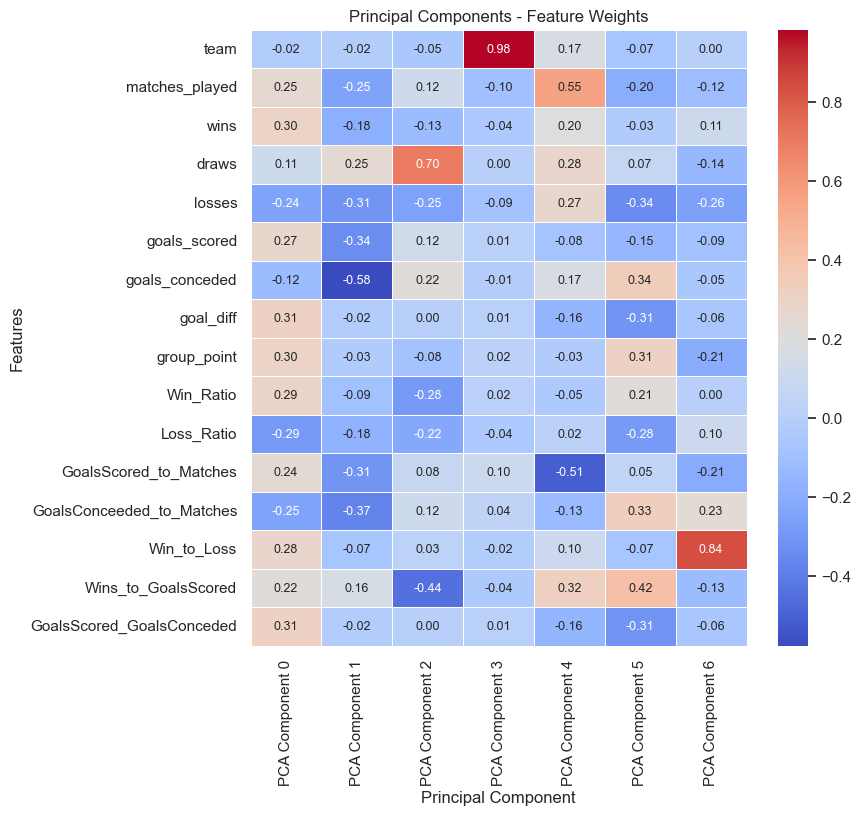

In [19]:
plt.figure(figsize=(8, 8))
sns.heatmap(pca_test_df.head(7).T, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 9}, linewidths=0.5)
plt.title('Principal Components - Feature Weights')
plt.xlabel('Principal Component')
plt.ylabel('Features')
plt.show()

For each column in the heatmap, the feature with the highest positive value whose color is closest to the most intense red color is the feature with the strongest weight in that given component (column).

# Modelling

For modelling our research question, we will explore three of the machine learning models discussed in class each for their own reasons.
- **Random Forest:** Probably the best model to use for this, random forests handle complex relationships and interactions between features and its ensemble nature helps in reducing overfitting and capturing the underlying patterns effectively. Given the complex nature of football data and the potential non-linear relationships between performance metrics and winning, Random Forest can capture these complexities effectively.

- **K-Nearest Neighbors:** KNNs are intuitive and easy to understand, and capture local patterns in a given dataset. They can handle datasets with noisy or irregular boundaries, which might be present in our football teams historical performance data.

- **Support Vector Machines:** SVMs on the other hand are quite effective in high-dimensional spaces, making it suitable for datasets with many features like our historical performance data. It ususally aims to find the optimal hyperplane that maximizes the margin between classes, which can be beneficial in separating different classes of Champions League winners.


## Random Forest

Now that we have successfully scaled our features and have our PCA ready with the right number of components, we can begin training our models fit our `X_train_scaled_pca` and `y_train data` to s Random Forest model, to see if we get any improvement on the model’s predictions. We also calculate and view the model's accuracy using the `score` method of the `RandomForestClassifier`.

In [57]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state= RANDOM_SEED)
rfc.fit(X_train_scaled_pca, y_train)
print("Accuracy:", rfc.score(X_train_scaled_pca, y_train))

Accuracy: 1.0


### Make First Predictions with Test Set

Now we are ready to make predictions on our scaled test set, `X_test_scaled_pca` using our model.

In [21]:
y_pred_pca = rfc.predict(X_test_scaled_pca)
y_pred_pca

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

We calculate the performance metrics of our model, comparing its predictions for the dependent variable `y_pred_pca` for the actual occured values `y_test`. We calculate the presicion and recall using the appropriate method from the scikit-learn library.

In [22]:
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

# Calculate precision
precision = precision_score(y_test, y_pred_pca)

# Calculate recall
recall = recall_score(y_test, y_pred_pca)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.625
Recall: 0.625


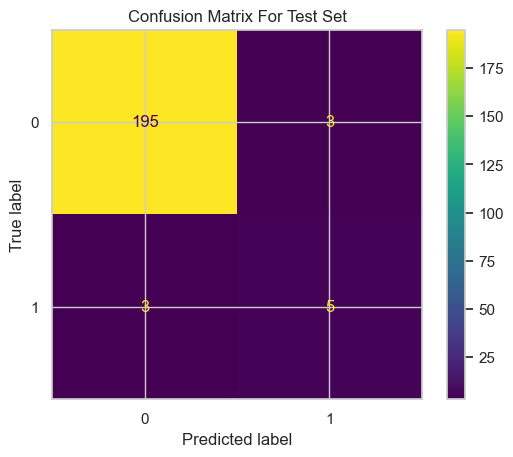

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_pca)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.title('Confusion Matrix For Test Set')
plt.show()

## Class Imbalance

Both from common knowledge and by looking at our dataset we can observe that there is a relatively large imbalance in the two values of the target variable, `champions`. Each year there will always only be one champion denoted at `1` whereas all other teams will be non champions or `0`s. We can observe this more easily through a bar chart displaying the counts of the two classes.

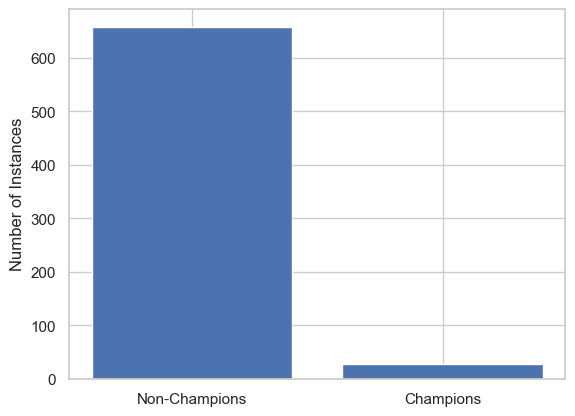

In [24]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1], ['Non-Champions', 'Champions'])
plt.ylabel('Number of Instances')
plt.show()

We can see that a bias exists as there are much more non-champions in our dataset. This will have a significant impact on the performance of our models, since such data tend to be biased towards the majority class.

There are several ways to evaluate this imbalance and its effects on our model. One way is by observing the not too great recall and precision values for our model. **Since this problem is mainly about correctly identifying the champions, we want to minimize false negatives as much as we can. This means that a high recall should be preferred for this model.**

Another way to evaluate this imbalance is by looking at its ***balanced accuracy***. Balanced accuracy is a metric that takes into account the class imbalance by averaging the recall score of each class.

In [25]:
# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred_pca)

print('Balanced accuracy:', balanced_acc)

Balanced accuracy: 0.8049242424242424


We see that the balanced accuracy is way less than regular accuracy.

## Fixing Class Imbalance

All these are pointing to problems with our model arising largely from the imbalance issue. There are a few ways to fix class imbalance when building machine learning models, some of which include **undersampling**, **oversampling**, and **a combination of both** among a few. Undersampling is a somewhat simple technique which involves reducing the number of samples from the majority class to balance the class distribution in the training data. However, this is not usually the best technique to use in most cases as discarding data means that we lose a significant chunk of information. 

Oversampling on the other hand,does the exact opposite. Here, we systematically generate duplicates of the minority class to match the count of the majority class. Using this technique, we do not lose information no samples are discarded. **It also reduces the risk of overfitting because it generates synthetic samples that are not identical to the original samples.**

To see which technique performs best for our model, we will resample our dataset using the two techniques and compare their performance via the performance metrics. We also try some hyperparameter tuning on the two Random Forest models trained using resampled data from each of the two techniques. This is to explore and compare the effects of optimization of the two different models.

### Undersampling

As stated earlier, this is a simple technique where we reduce the size of the data that we push into the models. However, it should be noted that this can reduce the overall performance of the model and the quality of generalization. 

It is relatively easy to use undersampling for our problem by using the `RandomUnderSampler` function from the `imbalanced-learn` package.

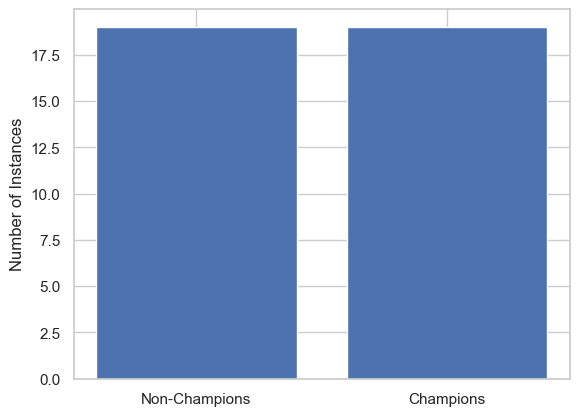

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# undersample
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled_pca, y_train)

# plot the new distribution
unique, counts = np.unique(y_train_undersampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1], ['Non-Champions', 'Champions'])
plt.ylabel('Number of Instances')
plt.show()

After undersampling, we now have relatively equal samples for each class. You will notice that the majority class, Non-champions was significantly slashed to meet up with the count of the minority class as expected.

We go ahead to train a new Random Forest model with our new resampled data, naming it `rfc_undersampled`.

In [27]:
rfc_undersampled = RandomForestClassifier(random_state=RANDOM_SEED)
rfc_undersampled.fit(X_train_undersampled, y_train_undersampled)
print("Accuracy:", rfc_undersampled.score(X_train_undersampled, y_train_undersampled))

Accuracy: 1.0


Normal accuracy remains unchanged, so we calculate the balanced accuracy, precision and recall to see if there is any improvement.

In [28]:
y_pred_pca_undersampled = rfc_undersampled.predict(X_test_scaled_pca)
balanced_acc_undersampled = balanced_accuracy_score(y_test, y_pred_pca_undersampled)

print('Resampled Balanced accuracy:', balanced_acc_undersampled)

# Calculate precision
precision_undersampled = precision_score(y_test, y_pred_pca_undersampled)

# Calculate recall
recall_undersampled = recall_score(y_test, y_pred_pca_undersampled)

# Print precision and recall
print("ResampledPrecision:", precision_undersampled)
print("Resampled Recall:", recall_undersampled)

Resampled Balanced accuracy: 0.8743686868686869
ResampledPrecision: 0.21875
Resampled Recall: 0.875


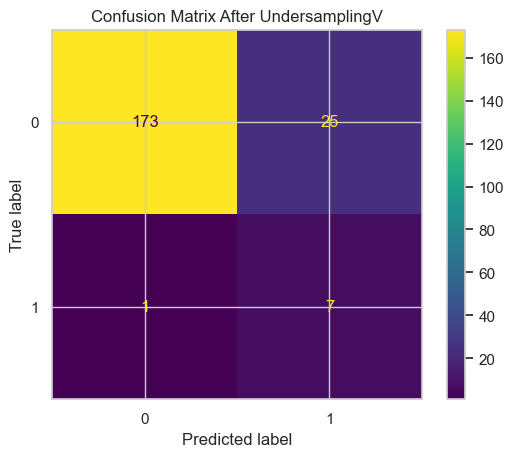

In [29]:
cm_undersampled= confusion_matrix(y_test, y_pred_pca_undersampled)

cm_display_undersampled = ConfusionMatrixDisplay(confusion_matrix = cm_undersampled, display_labels = [0, 1])

cm_display_undersampled.plot()
plt.title('Confusion Matrix After UndersamplingV')
plt.show()

As seen we get a significant improvement in our recall and balanced accuracy. However, our precision value tends to plummet. This is as a result of undersampling. Undersampling often leads to an improvement in recall, but at the expense of sacrificing precision.

### Hyperparameter Tuning / Cross-Validation

We can try to even further optimize our Random Forest by tweaking its hyperparameters.

#### RandomSearchCV for Undersampled Random forest

First, we can start with RandomSearchCV to consider a wide range of values for these different hyperparameters. It randomly samples these values from a given distribution, hence its name. 

For this to work as expected, we first need to specify the hyperparameter distributions to sample from during the random search. This is done by defining a `param_dist` variable with a range of values to try for each hyperparameter. `bootstrap` here refers to whether or not we want to use random sampling from the dataset with replacement to provide data to each tree in the Random Forest. We then instantiate the `RandomSearchCV` function from scikit-learn and pass in the required parameters for this function. Our resampled Random Forest model is passed in first, then our `param_dist`, the number of iterations to try, and the number of cross-validations to perform, which is 3 in our case. 

The last two parameters are optional. We set `verbose` to `True` in order to receive updates as the model runs. The `n_jobs` parameter is used to define how many cores in our computer we wish to use to run this model. Setting this to `-1` uses all the computer cores, ensuring our model runs as fast as possible

In [30]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_undersampled,  # Using the undersampled Random Forest model
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED)
rs.fit(X_train_undersampled, y_train_undersampled)
print("Done fitting model")  # Takes about 15 seconds to complete

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done fitting model


As we can see above, by setting `n_iter = 100` and `cv = 3`, we created 300 Random Forest models, randomly sampling combinations of the hyperparameters input above.

While RandomSearch gives us a good estimate of the hyperparameter values, its estimate not not necessarily be the best option for our model. To confirm the best estimates, we perform a second cross-validation methiod using **GridSearchCV**. To get a good range of values to try next with our GridSearhCV, we can easily get a dataframe of our RandomSearchCV results and create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average.

In [31]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,500,23,12,log2,1,False,0.948718,1
1,200,12,12,log2,11,False,0.923077,2
2,900,12,7,sqrt,3,True,0.923077,2
3,500,2,7,sqrt,7,False,0.897436,4
4,700,12,7,log2,2,False,0.897436,4
5,100,2,2,log2,8,True,0.895299,6
6,700,12,2,log2,15,True,0.895299,6
7,200,2,2,sqrt,10,True,0.895299,6
8,100,18,7,sqrt,13,False,0.871795,9
9,600,18,7,log2,3,True,0.871795,9


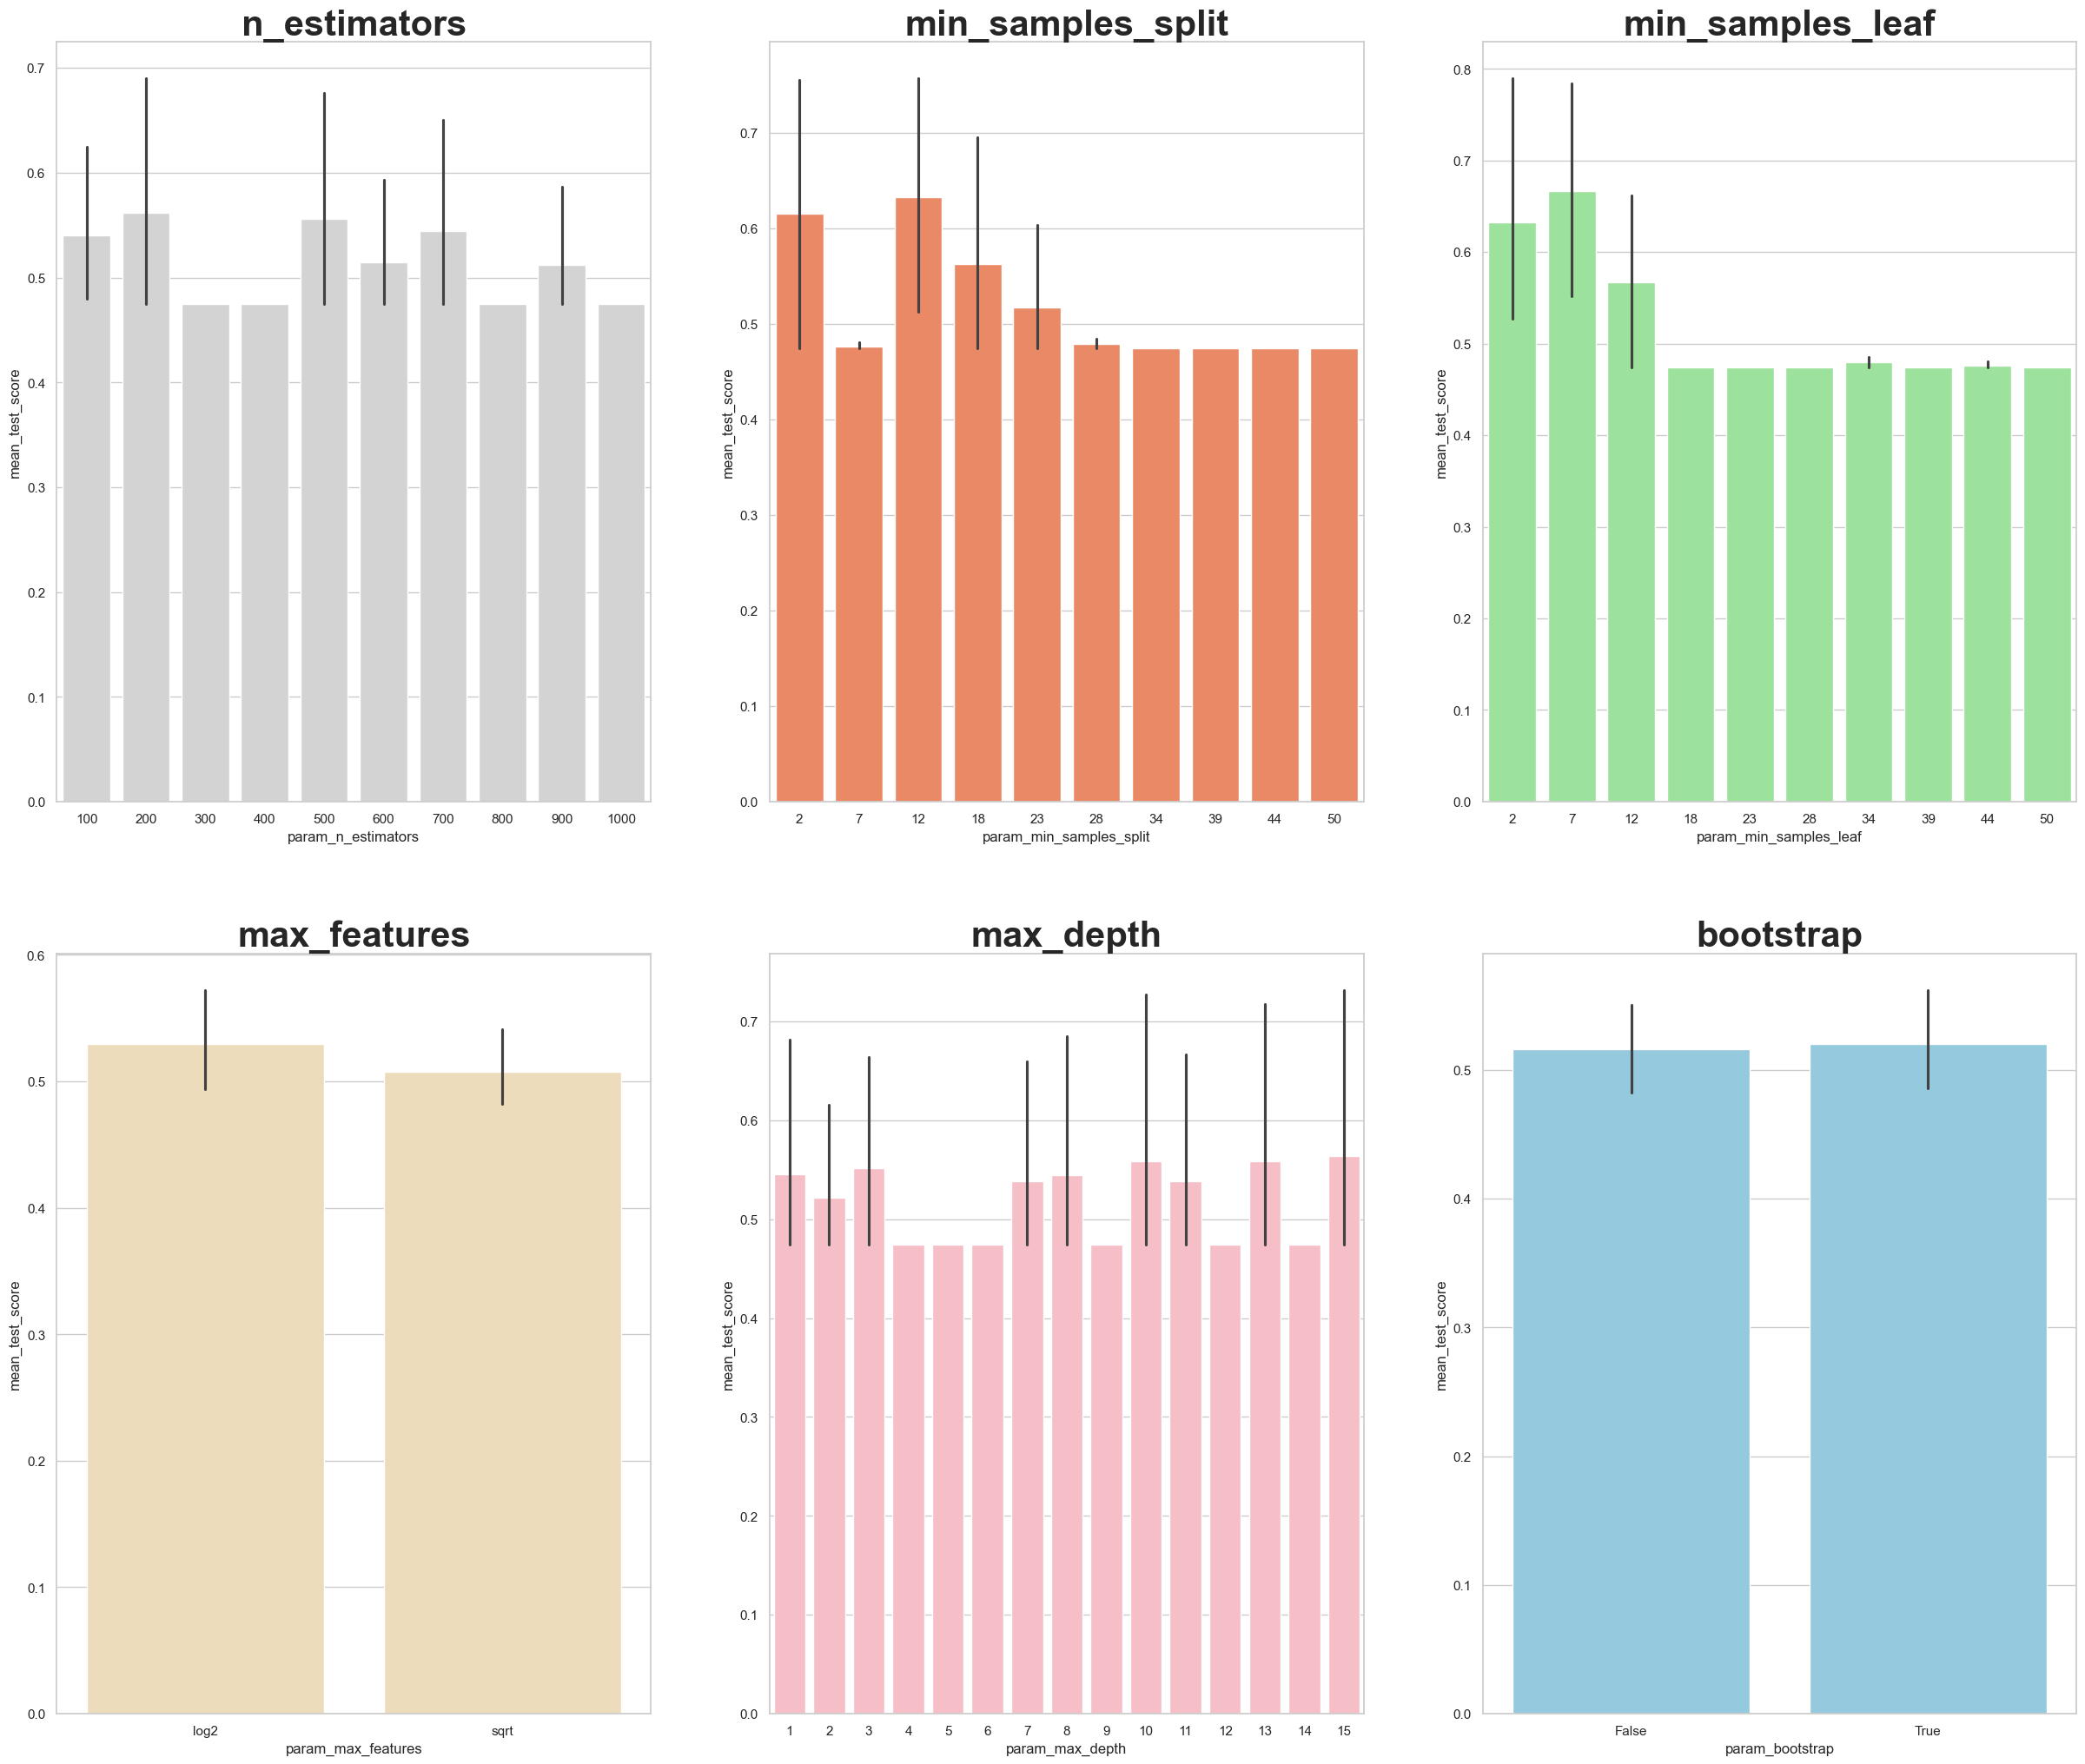

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()


### GridSearchCV for Undersampled Random forest

The plots above give us the results of our RandomSearchCV. By looking at these plots, we can extract insights about how well each value for each hyperparameter performed on average. We can now use GridSearchCV to perform a more refined search for our best hyperparameters after narrowing down the values.

GridSearchCV performs a more exhaustive search, since every single combination of hyperparameter values is tried. This is significantly more exhaustive and takes more computational power than the RandomSearchCV, which allows us to directly control how many iterations we want to try. (_NB:_ We tried 100 for ours by setting, `n_iter = 100`). We performed RandomSearchCV first to help narrow down these values.

We extract the best performing values from the plots of the RandomSearchCv results into array, which are simply the higher values in each plot and feed them into our our `GridSearchCV` function as `param_grid`.

In [33]:
from sklearn.model_selection import GridSearchCV
n_estimators = [200,500,700]
max_features = ['log2']
max_depth = [1,3,7,8,10,11,13,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,7,12]
bootstrap = [True]
                    
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                    
gs = GridSearchCV(rfc_undersampled, # Still using the undersampled Random Forest model
                  param_grid, 
                  cv = 3, 
                  verbose = 1, 
                  n_jobs=-1)
                    
gs.fit(X_train_undersampled, y_train_undersampled) # Completes in about 1 minute
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


{'bootstrap': True,
 'max_depth': 1,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 200}

Once the GridSearchCV is complete, we can now call `best_params_` to get the one best model to try and predict our data as shown above.

After this hyperparameter tuning, we can then go ahead to calculate the model performance metrics on our new model as shown below.

In [34]:
y_pred_gs_undersampled = rfc_3.predict(X_test_scaled_pca)
gs_undersampled_accuracy = balanced_accuracy_score(y_test, y_pred_pca_undersampled)

print('GridSearchCV Undersampled Balanced Accuracy:', gs_undersampled_accuracy)

# Calculate precision
precision_gs_undersampled = precision_score(y_test, y_pred_gs_undersampled)

# Calculate recall
recall_gs_undersampled = recall_score(y_test, y_pred_gs_undersampled)

# Print precision and recall
print("GridSearchCV Undersampled Precision:", precision_gs_undersampled)
print("GridSearchCV Undersampled Recall:", recall_gs_undersampled)

GridSearchCV Undersampled Balanced Accuracy: 0.8743686868686869
GridSearchCV Undersampled Precision: 0.22580645161290322
GridSearchCV Undersampled Recall: 0.875


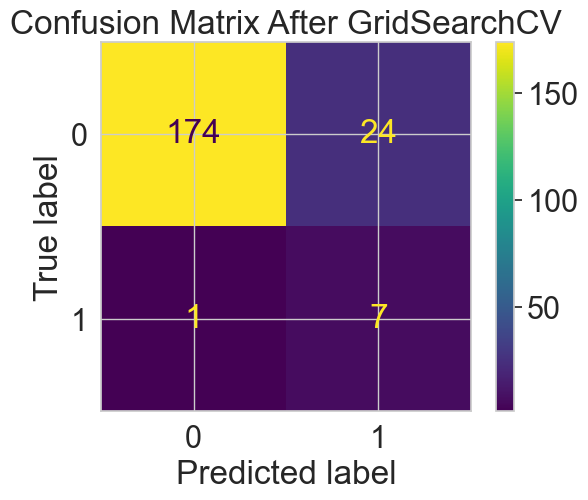

In [35]:
cm_gs_undersampled= confusion_matrix(y_test, y_pred_gs_undersampled)

cm_display_gs_undersampled = ConfusionMatrixDisplay(confusion_matrix = cm_gs_undersampled, display_labels = [0, 1])

cm_display_gs_undersampled.plot()
plt.title('Confusion Matrix After GridSearchCV')
plt.show()

As seen, we got little to no improvement from our resampled model after hyperparameter tuning. We observe just a slight percentage increase in precision, but balanced accuracy and recall pretty much stay the same. As a result, we can conclude that hyperparameter tuning contributed little or no improvements to the performance of our "un-tuned" model.

### Oversampling

Since we are done with undersampling, we can now try the second technique, oversampling for comparison. We use `imblearn`s SMOTE package here.

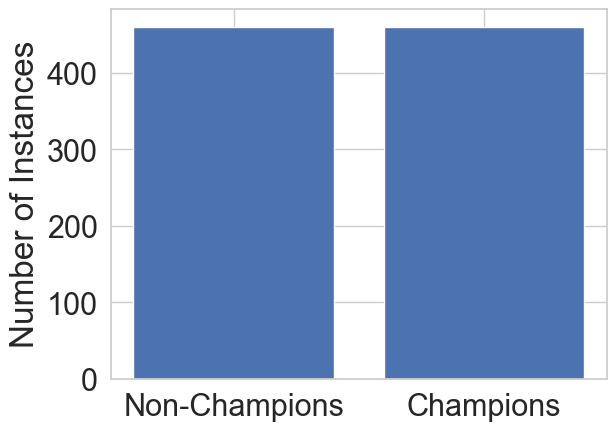

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled_pca, y_train)

rfc_oversampled = RandomForestClassifier(random_state=RANDOM_SEED)
rfc_oversampled.fit(X_train_oversampled, y_train_oversampled)

# plot the new distribution
unique, counts = np.unique(y_train_oversampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1], ['Non-Champions', 'Champions'])
plt.ylabel('Number of Instances')
plt.show()

y_pred_oversampled = rfc_oversampled.predict(X_test_scaled_pca)

From the plot above we notice that we now have signifcantly more data samples for the minority class `Champions`.

We go ahead to evaluate the performance of the plain oversampled Random Forest model.

In [37]:
balanced_acc_oversampled = balanced_accuracy_score(y_test, y_pred_oversampled)

print('Oversampled Balanced accuracy:', balanced_acc_oversampled)

# Calculate precision
precision_oversampled = precision_score(y_test, y_pred_oversampled)

# Calculate recall
recall_oversampled = recall_score(y_test, y_pred_oversampled)

# Print precision and recall
print("Oversampled Precision:", precision_oversampled)
print("Oversampled Recall:", recall_oversampled)

Oversampled Balanced accuracy: 0.7771464646464646
Oversampled Precision: 0.2631578947368421
Oversampled Recall: 0.625


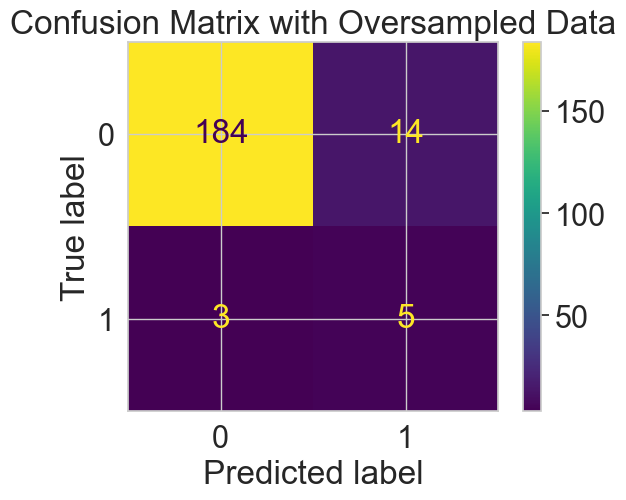

In [38]:
cm_oversampled= confusion_matrix(y_test, y_pred_oversampled)

cm_display_oversampled = ConfusionMatrixDisplay(confusion_matrix = cm_oversampled, display_labels = [0, 1])

cm_display_oversampled.plot()
plt.title('Confusion Matrix with Oversampled Data')
plt.show()

We notice that this performs worse than our plain undersampled random forest model, as the numbers for both the balanced accuracy and recall are significantly lower here.

Let's see what happens after hyperparameter tuning and optimizations.

#### GridSearchCV for Oversampled Random forest

In [59]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 5)]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs2 = GridSearchCV(rfc_oversampled, 
                  param_grid, 
                  cv = 3, 
                  verbose = 1, 
                  n_jobs=-1)
gs2.fit(X_train_oversampled, y_train_oversampled) # Completes in about 1 hour

rfc_4 = gs2.best_estimator_
gs2.best_params_

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [62]:
y_pred_gs_oversampled = rfc_4.predict(X_test_scaled_pca)
balanced_accuracy_gs_oversampled = balanced_accuracy_score(y_test, y_pred_gs_oversampled)

print('GridSearchCV balanced accuracy:', balanced_accuracy_gs_oversampled)

# Calculate precision
precision_gs_oversampled = precision_score(y_test, y_pred_gs_oversampled)

# Calculate recall
recall_gs_oversampled = recall_score(y_test, y_pred_gs_oversampled)

# Print precision and recall
print("GridSearchCV Oversampled Precision:", precision_gs_oversampled)
print("GridSearchCV Oversampled Recall:", recall_gs_oversampled)

GridSearchCV balanced accuracy: 0.7771464646464646
GridSearchCV Oversampled Precision: 0.2631578947368421
GridSearchCV Oversampled Recall: 0.625


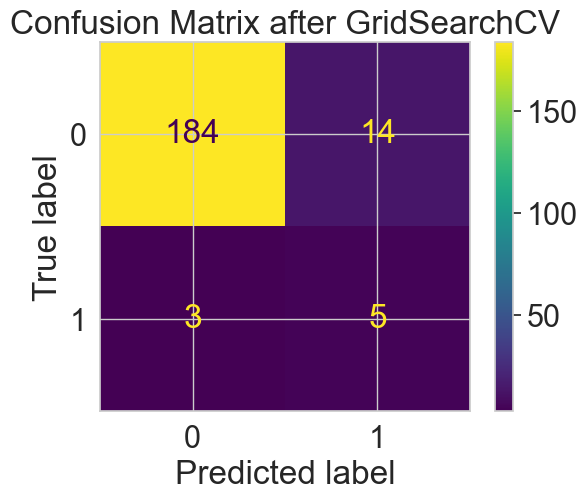

In [63]:
cm_gs_oversampled= confusion_matrix(y_test, y_pred_gs_oversampled)

cm_display_gs_oversampled = ConfusionMatrixDisplay(confusion_matrix = cm_gs_oversampled, display_labels = [0, 1])

cm_display_gs_oversampled.plot()
plt.title('Confusion Matrix after GridSearchCV')
plt.show()

You can see that we got a signifcant jump in our recall, which is the main metric we are concerned about. And since we still have ample data as no data was discarded from the dataset unlike during the undersampled technique, we can be somewhat confident in the results of this particular model.

## Trying Other Models

We've finally completed our extensive modellings using the Random Forest model. However, as mentioned earlier, it might be beneficial to explore the effectiveness of other models in making our predictions. Going forward, we will use our oversampled data, `X_train_oversampled` and `y_train_oversampled` for training our models as they tend to produce the best results.

## K-Nearest Neighbors (kNN)

The second model we will explore is the K-Nearest Neighboors (k-NN) model. We first begin by importing the kNN classifiier from the scikit learn library and initializzing it as `knn`.

k-NN Precision: 0.20689655172413793
k-NN Recall: 0.75


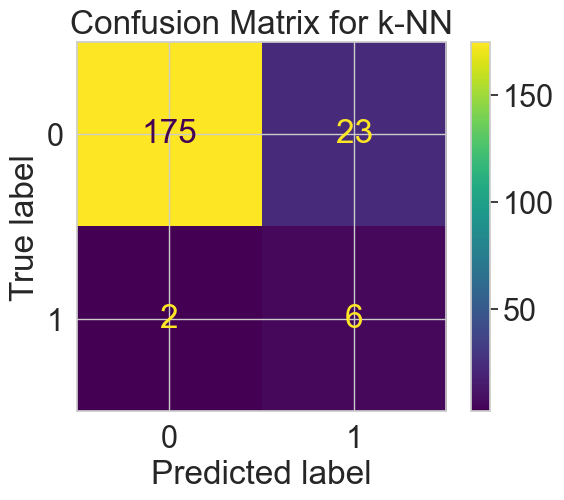

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Training the model
knn.fit(X_train_oversampled, y_train_oversampled)

# Predict test data set
y_pred_knn = knn.predict(X_test_scaled_pca)

# Calculate precision
precision_knn = precision_score(y_test, y_pred_knn)

# Calculate recall
recall_knn = recall_score(y_test, y_pred_knn)

# Print precision and recall
print("k-NN Precision:", precision_knn)
print("k-NN Recall:", recall_knn)

# Create confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

cm_knn_display = ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = [0, 1])

cm_knn_display.plot()
plt.title('Confusion Matrix for k-NN')
plt.show()

### Hyperparameter tuning with k-NN

We can also apply GridSearchCV to our kNN model to tune and determine the best hyperparameter values for our model just like we did for our random forest. Here the hyperparameter we tune will be `n_neighbors` which defines the number of neighbors our model uses during its training.

In [65]:
parameter = {'n_neighbors': [int(x) for x in np.linspace(start = 2, stop = 52, num = 50)]}

knn_gscv = GridSearchCV(knn, param_grid=parameter, cv=3, verbose=1)

knn_gscv.fit(X_train_oversampled, y_train_oversampled)
print(knn_gscv.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_neighbors': 2}


We can now train a new knn model using this tuned parameter value and evaluate its performance.

Tuned k-NN Precision: 0.29411764705882354
Tuned k-NN Recall: 0.625


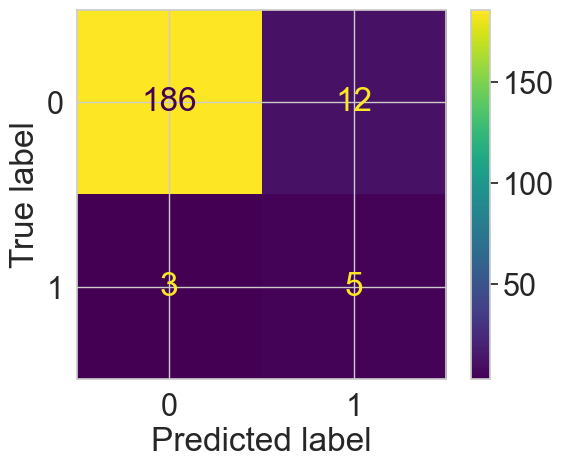

In [66]:
knn_tuned = KNeighborsClassifier(n_neighbors=2)
knn_tuned.fit(X_train_oversampled, y_train_oversampled)

y_pred_knn_tuned = knn_tuned.predict(X_test_scaled_pca)

# Calculate precision
precision_knn_tuned = precision_score(y_test, y_pred_knn_tuned)

# Calculate recall
recall_knn_tuned = recall_score(y_test, y_pred_knn_tuned)

# Print precision and recall
print("Tuned k-NN Precision:", precision_knn_tuned)
print("Tuned k-NN Recall:", recall_knn_tuned)

# Create confusion matrix
cm_knn_tuned = confusion_matrix(y_test, y_pred_knn_tuned)

cm_knn_tuned_display = ConfusionMatrixDisplay(confusion_matrix = cm_knn_tuned, display_labels = [0, 1])

cm_knn_tuned_display.plot()

## Support Vector Machine (SVM)

The final model we will be trying for this project will be a Support Vector Machine. To do this we use the Support Vector Classifier (SVC) function available from scikit learn, then we basically do the exact same steps as our previous models - train the model with our oversampled train dataset, make predictions using our test set, then evaluate the model's performance using our normal metrics, as well as visualizing this with a confusion matrix.

SVM Precision: 0.17391304347826086
SVM Recall: 0.5


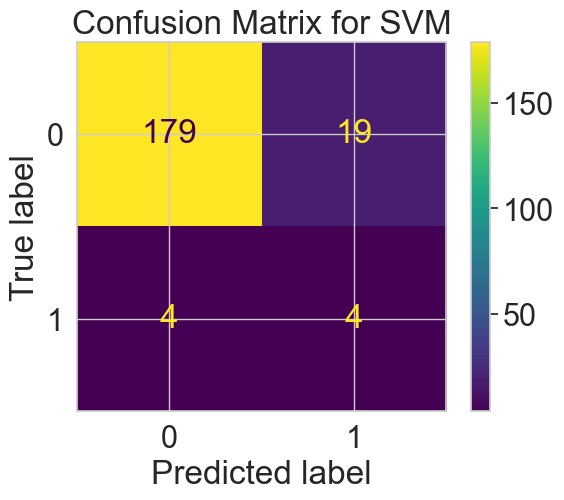

In [67]:
from sklearn.svm import SVC 

svc = SVC()

# Training the model
svc.fit(X_train_oversampled, y_train_oversampled)

# Predict test data set
y_pred_svc = svc.predict(X_test_scaled_pca)

# Calculate precision
precision_svc = precision_score(y_test, y_pred_svc)

# Calculate recall
recall_svc = recall_score(y_test, y_pred_svc)

# Print precision and recall
print("SVM Precision:", precision_svc)
print("SVM Recall:", recall_svc)

# Create confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)

cm_svc_display = ConfusionMatrixDisplay(confusion_matrix = cm_svc, display_labels = [0, 1])

cm_svc_display.plot()
plt.title('Confusion Matrix for SVM')
plt.show()

### Hyperparameter tuning with SVM

Just like we did with our previous models, we will now go ahead to tune the hyperparameters of our SVM model. The hyperparameters we will be tuning in this case are `C`, the regularization parameterand `gamma`, our kernel coefficient. 

In [87]:
param_grid = {'C': [int(x) for x in np.linspace(start = 1, stop = 1000, num = 20)], #[0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  
  
svm_grid = GridSearchCV(svc, param_grid, verbose = 1)
  
# fitting the model for grid search 
svm_grid.fit(X_train_oversampled, y_train_oversampled)

svc_gscv = svm_grid.best_estimator_
print("Best parameters:", svm_grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'C': 158, 'gamma': 0.1}


Calculating and using a confusion matrix to visualize our model's performance after GridSearchCV...

SVM GridSearchCV Precision: 0.4
SVM GridSearchCV Recall: 0.5



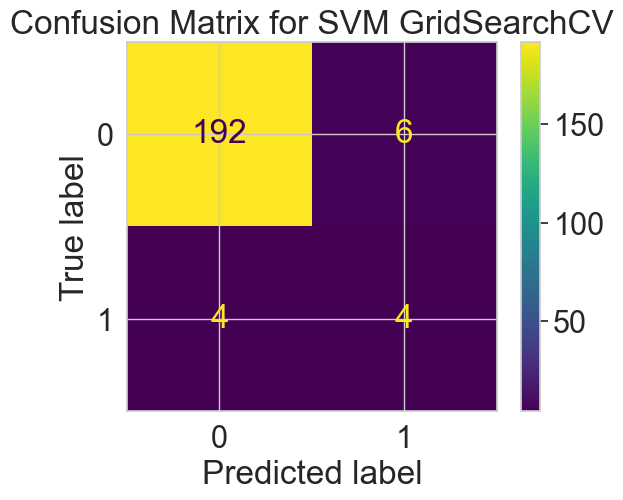

In [85]:
# Predict test data set
y_pred_svc_gcsv = svc_gscv.predict(X_test_scaled_pca)

# Calculate precision
precision_svc_gcsv = precision_score(y_test, y_pred_svc_gcsv)

# Calculate recall
recall_svc_gcsv = recall_score(y_test, y_pred_svc_gcsv)

print("SVM GridSearchCV Precision:", precision_svc_gcsv)
print("SVM GridSearchCV Recall:", recall_svc_gcsv)
print()

# Create confusion matrix
cm_svc_gcsv = confusion_matrix(y_test, y_pred_svc_gcsv)

cm_svc_gscv_display = ConfusionMatrixDisplay(confusion_matrix = cm_svc_gcsv, display_labels = [0, 1])

cm_svc_gscv_display.plot()
plt.title('Confusion Matrix for SVM GridSearchCV')
plt.show()

We observe a somewhat significant improvement in our SVM model precision after hyperparameteer tuning. However, the recall stays the same.

## Making Our Predictions
Now that we have all our models trained and tested, it's time to see what predictions each of these models make for the 2024 UEFA Champions League Tournament. But before that we need to make sure our data is ready to be fed to these models. We need to perform all the modifications we made to our training dataset on our real/actual dataset now, including feature engineering techniques, generating the same new features for the table, encoding categorical features, and scaling our features using the PCA feature scaler we already have. 

We go ahead and import the data for the teams left in the Champions Leage into its own dataset, `real.csv`.

In [70]:
real = pd.read_csv('real.csv')
test = real.copy()
test

,Club,Participated,Titles,Played,Win,Draw,Loss,Goals For,Goals Against,Pts,Goal Diff
0,Real Madrid CF,53,14,476,285,81,110,1047,521.0,651.0,526.0
1,FC Bayern München,39,6,382,229,76,77,804,373.0,534.0,431.0
2,FC Barcelona,33,5,339,197,76,66,667,343.0,470.0,324.0
3,Arsenal FC,21,0,201,101,43,57,332,218.0,245.0,114.0
4,Borussia Dortmund,21,1,170,81,33,56,287,214.0,195.0,73.0
5,Club Atlético de Madrid,18,0,160,76,42,42,226,152.0,194.0,74.0
6,Paris Saint-Germain,16,0,143,77,27,39,283,166.0,181.0,117.0
7,Manchester City FC,13,1,119,66,24,29,245,131.0,156.0,114.0


Once we have our dataset of the teams left in the championship, we go ahead and encode the categorical variables necessary for our model, specifically the names of the different teams, "Club" in this case.

In [71]:
test['Club'] = test['Club'].astype('category').cat.codes
test

,Club,Participated,Titles,Played,Win,Draw,Loss,Goals For,Goals Against,Pts,Goal Diff
0,7,53,14,476,285,81,110,1047,521.0,651.0,526.0
1,4,39,6,382,229,76,77,804,373.0,534.0,431.0
2,3,33,5,339,197,76,66,667,343.0,470.0,324.0
3,0,21,0,201,101,43,57,332,218.0,245.0,114.0
4,1,21,1,170,81,33,56,287,214.0,195.0,73.0
5,2,18,0,160,76,42,42,226,152.0,194.0,74.0
6,6,16,0,143,77,27,39,283,166.0,181.0,117.0
7,5,13,1,119,66,24,29,245,131.0,156.0,114.0


We also rename some of the columns/features for consistency.

In [72]:
# Rename necessary features
test = test.rename(columns={'Participated': 'matches_played', 'Win': 'wins', 'Loss': 'losses', 'Goals For': 'goals_scored', 'Goals Against' : 'goals_conceded', 'Goal Diff': 'goal_diff'})
test.drop(['Titles', 'Pts'], axis = 1, inplace = True)
test.head()

,Club,matches_played,Played,wins,Draw,losses,goals_scored,goals_conceded,goal_diff
0,7,53,476,285,81,110,1047,521.0,526.0
1,4,39,382,229,76,77,804,373.0,431.0
2,3,33,339,197,76,66,667,343.0,324.0
3,0,21,201,101,43,57,332,218.0,114.0
4,1,21,170,81,33,56,287,214.0,73.0


It is also neccessary to compute the features we previously computed on our data during the training and testing phases.

In [73]:
test['Win_Ratio'] = (test['wins']) / test['matches_played']
test['Loss_Ratio'] = (test['losses']) / test['matches_played']
test['GoalsScored_to_Matches'] = (test['goals_scored']) / test['matches_played']
test['GoalsConceeded_to_Matches'] = (test['goals_conceded']) / test['matches_played']
test['Win_to_Loss'] = (test['wins']) / (test['losses'] + 1)
test['Wins_to_GoalsScored'] = (test['wins']) / (test['goals_scored'] + 1) 
test['GoalsScored_GoalsConceded'] = (test['goals_scored'] - test['goals_conceded']) + 0.1
test

,Club,matches_played,Played,wins,Draw,losses,goals_scored,goals_conceded,goal_diff,Win_Ratio,Loss_Ratio,GoalsScored_to_Matches,GoalsConceeded_to_Matches,Win_to_Loss,Wins_to_GoalsScored,GoalsScored_GoalsConceded
0,7,53,476,285,81,110,1047,521.0,526.0,5.377358,2.075472,19.754717,9.830189,2.567568,0.271947,526.1
1,4,39,382,229,76,77,804,373.0,431.0,5.871795,1.974359,20.615385,9.564103,2.935897,0.284472,431.1
2,3,33,339,197,76,66,667,343.0,324.0,5.969697,2.000000,20.212121,10.393939,2.940299,0.294910,324.1
3,0,21,201,101,43,57,332,218.0,114.0,4.809524,2.714286,15.809524,10.380952,1.741379,0.303303,114.1
4,1,21,170,81,33,56,287,214.0,73.0,3.857143,2.666667,13.666667,10.190476,1.421053,0.281250,73.1
5,2,18,160,76,42,42,226,152.0,74.0,4.222222,2.333333,12.555556,8.444444,1.767442,0.334802,74.1
6,6,16,143,77,27,39,283,166.0,117.0,4.812500,2.437500,17.687500,10.375000,1.925000,0.271127,117.1
7,5,13,119,66,24,29,245,131.0,114.0,5.076923,2.230769,18.846154,10.076923,2.200000,0.268293,114.1


In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Club                       8 non-null      int8   
 1   matches_played             8 non-null      int64  
 2   Played                     8 non-null      int64  
 3   wins                       8 non-null      int64  
 4   Draw                       8 non-null      int64  
 5   losses                     8 non-null      int64  
 6   goals_scored               8 non-null      int64  
 7   goals_conceded             8 non-null      float64
 8   goal_diff                  8 non-null      float64
 9   Win_Ratio                  8 non-null      float64
 10  Loss_Ratio                 8 non-null      float64
 11  GoalsScored_to_Matches     8 non-null      float64
 12  GoalsConceeded_to_Matches  8 non-null      float64
 13  Win_to_Loss                8 non-null      float64
 14

Now that our changes are done for our dataset and it is ready to go, we are almost ready to try out our models. The final step just before this exciting part where we get to view our results, is to scale our features then transform this test data set using our previously fitted PCA.

In [74]:
# Standardize/Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(test)
test_pca = pca.transform(scaled_features)

Making our predictions now involves feeding the results of our new data's PCA transformation into all our trained claccifiers and observing the predictions and results.

### Random Forest

For our random forest model predictions, we use our undersampled data model after GridSearchCV since it technically gave the highest recall values. These are the prediction results of the random forest model after oversampling and hyperparameter tuning with GridSearchCV.

In [81]:
# Make Random Forest Predictions
y_pred_rfc3 = rfc_3.predict(test_pca) #rfc_4.predict(test_pca)
rfc3_df = pd.DataFrame({'Champions': y_pred_rfc3})

rfc3_predictions = pd.concat([real["Club"], rfc3_df], axis=1)
rfc3_predictions

,Club,Champions
0,Real Madrid CF,1
1,FC Bayern München,0
2,FC Barcelona,0
3,Arsenal FC,0
4,Borussia Dortmund,0
5,Club Atlético de Madrid,0
6,Paris Saint-Germain,0
7,Manchester City FC,0


### K-Nearest Neighbors (k-NN)

Likewise, these are the predictions for our k-NN model after oversampling and hyperparameter tuning with GridSearchCV.

In [82]:
# Make k-NN Predictions
y_pred_knn = knn_tuned.predict(test_pca)
knn_df = pd.DataFrame({'Champions': y_pred_knn})

knn_predictions = pd.concat([real["Club"], knn_df], axis=1)
knn_predictions

,Club,Champions
0,Real Madrid CF,0
1,FC Bayern München,1
2,FC Barcelona,0
3,Arsenal FC,0
4,Borussia Dortmund,0
5,Club Atlético de Madrid,0
6,Paris Saint-Germain,0
7,Manchester City FC,0


### Support Vector Machine (SVM)

Finally, our SVM model predictions after oversampling our training data and hyperparameter tuning of the model with GridSearchCV are as follows.

In [90]:
# Make SVM Predictions
y_pred_svm = svc_gscv.predict(test_pca)
svm_df = pd.DataFrame({'Champions':y_pred_svm})

svm_predictions = pd.concat([real["Club"], svm_df], axis=1)
svm_predictions

,Club,Champions
0,Real Madrid CF,0
1,FC Bayern München,1
2,FC Barcelona,1
3,Arsenal FC,0
4,Borussia Dortmund,0
5,Club Atlético de Madrid,0
6,Paris Saint-Germain,0
7,Manchester City FC,0


## Conclusion/Final Discussion

The aim of this project was to asnwer the question: **Can we predict the winners of the 2024 Champions League Tournament with machine learning?** From our exploration, analysis and modelling, we are confident to say **yes, we can!** While our different models did give different results, it only makes sense to go with whichever model had the best results for the performance metric we are most concerned about, being recall. In our case, this turned out to be our random forest model with undersampled data. 

This means that at the end of the Champions League tournament sometime this summer, we expect Real Madrid to emerge as champions🏆

### *🏆🏆 Hala Madrid!!!🏆🏆*